In [1]:
# This is an example for the application of the Python tool "PHT3D-FSP" (PHT3D - FloPy Support Package)
# This work was realized in the Deutsche Forschungsgemeinschaft (DFG) project Reactive Transport (GR 4514/3-1) within the research unit FOR 5094: The dynamic deep subsurface of high-energy beaches (DynaDeep).
# This work is published under the GNU GENERAL PUBLIC LICENSE Version 3.

## Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy
from subprocess import call
import sys
import pht3d_fsp # Import PHT3D-FSP

## Define paths and location of executables
path='.'
exe='/PATH/TO/MODFLOW/mf2005' 
modelname = 'PHT3D-FSP_example' 
model_ws = os.path.join(path, modelname)

flopy is installed in /home/janek/anaconda3/lib/python3.7/site-packages/flopy


In [ ]:
## Grid information
nlay = 1
nrow = 1
ncol = 300
delc = 1.
x=np.logspace(np.log10(5),np.log10(105),ncol+1)-5
delr = np.diff(x)
xi=x[0:-1]+delr/2
top = np.ones((1,ncol))*0 
botm = -1*np.ones((1,ncol)) 

## Temporal discretization
years=3 # Simulation time
nper = 365*years
perlen = 1 # 1 day
nstp = 10

## Ibound
ibound = np.ones((nlay,nrow,ncol))
ibound[0,0,-1]=-1

## Initiate model object
m = flopy.modflow.Modflow(modelname, model_ws=model_ws, exe_name=exe)

## Model parameters
K = 10 # Hydraulic conductivity [m/d]
n = 0.35 # Effective porosity
vka=K 
v = 0.27 # Pore water velocity m/d
Qf = v*n
aL = 0.2 # m

## Defining WEL data
wel_data = {}
wel_per=[]
wel_per.append([0,0,0,Qf])
wel_data[0]=wel_per

## Define FloPy packages
dis = flopy.modflow.ModflowDis(m, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, 
                               top=top, botm=botm, perlen=perlen, nstp=nstp,nper=nper, steady=True)
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=0)
lpf = flopy.modflow.ModflowLpf(m, laytyp=0,hk=K, vka=vka, ipakcb=53)
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-5, rclose=1e-6)
oc = flopy.modflow.ModflowOc(m)
wel = flopy.modflow.ModflowWel(m,stress_period_data=wel_data, ipakcb=53)
rch = flopy.modflow.ModflowRch(m,rech=1e-7)
lmt = flopy.modflow.ModflowLmt(m) ## this writes the mt3dms link file to be used by PHT3D later
m.write_input()
success, buff = m.run_model(silent=False)


In [23]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP

## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec=pht3d_fsp.create(xlsx_path="./", xlsx_name="pht3d_species_example.xlsx",
                 nlay=nlay, nrow=nrow, ncol=ncol,
                 ph_os=2,ph_temp=-2, ph_asbin=0, ph_eps_aqu=1e-10, 
                 ph_ph=1e-3, ph_print=0, ph_cb_offset=0.05, ph_surf_calc_type="-diffuse_layer",write_ph="yes")

## Re-define initial concentrations of species 'orgc'
x05=0.5
reac=20
spec['orgc'][0,0,:]=(reac*1e-3-1e-3)*np.exp(-np.log(2)/x05*xi)+1e-3

## Define ICBUND
icbund = np.abs(ibound)

## Initiate RCH data...
rch_spec={}
for key in spec.keys():
 rch_spec[key]={}

## Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words

## define dictionary for well species
wel_spec={}

for i in range(nper):
    
    # rch and wel
    for key in spec.keys():
     rch_spec[key][i]=spec[key][0,:,:] # set recharge concs to initial concs for simplicity 
     wel_spec[key]=spec[key][0,0,0] # set wel concs to initial concs for the beginning
    
    #change some well concs manually on the fly
    tempi=15.0/2.0*np.cos(np.float32(i)/365*2*np.pi-np.pi/2)+15.0/2.0+4
    ox=4.23e-4-(tempi-4)*(1.18e-4)/15.0*2
    nitr=(50e-6*np.cos(np.float32(i)/365*2*np.pi-np.pi)-20e-6)/3*6
    if nitr < 0:
        nitr = 0
        
    wel_spec['tracer']=1e-3    
    wel_spec['temp']=np.around(tempi,4)
    wel_spec['o2']=np.around(ox,5)
    wel_spec['no3']=np.around(nitr,6)
    wel_spec['cl']=4.317e-01
    wel_spec['ph']=8.2
    wel_spec['pe']=13.76
    
    ssm_per=[0,0,0,1.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
            
    ssm_data[i]=ssm_per
    


## Initiate model object
mt = flopy.mt3d.Mt3dms(modelname, model_ws=model_ws, exe_name='/PATH/TO/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=m, namefile_ext='nam_pht3d')

## Define FloPy packages
exec(f'btn = flopy.mt3d.Mt3dBtn(mt, nper=nper, perlen=perlen, nstp=nstp, nlay=nlay,ncol=ncol,nrow=nrow, \
    laycon=3, prsity=n, icbund=icbund, nprs=0,mxstrn=100000,tsmult=1, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.5)
kwargs={'dmcoef2':0.2}
dsp = flopy.mt3d.Mt3dDsp(mt, al=aL, trpt=0.1, trpv=0.1, multiDiff=True,dmcoef=0.0,**kwargs)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=2, cclose=1.e-10)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data,mxss=1000,{pht3d_fsp.create.crch_ssm})') # call SSM package in this way to invoke PHT3D-FSP variables
kwargs={'sp12':2e-4}
rct = flopy.mt3d.Mt3dRct(mt,rhob=1800.0,ireact=0,isothm=1,sp1=0,igetsc=0,**kwargs)
mt.write_input()

## Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

## This copies the pht3d specific files to the model folder
call(["cp", "pht3d_datab.dat", model_ws+"/pht3d_datab.dat"])
call(["cp", "pht3d_ph.dat", model_ws+"/pht3d_ph.dat"])

/home/janek/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/janek/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/home/janek/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5
DSP: setting dmcoef for component 6 to zero, kwarg name dmcoef6
DSP: setting dmcoef for component 7 to zero, kwarg name dmcoef7
DSP: setting dmcoef for component 8 to zero, kwarg name dmcoef8
DSP: setting dmcoef for component 9 to zero, kwarg name dmcoef9
DSP: setting dmcoef for component 10 to zero, kwarg name dmcoef10
DSP: setting dmcoef for component 11 to zero, kwarg name dmcoef11
DSP: setting dmcoef for component 12 to zero, kwarg name dmcoef12
DSP: setting dmcoef for component 13 to zero, kwarg name dmcoef13
DSP: setting dmcoef for component 14 to zero, kwarg name dmcoef14
DSP: setting dmcoef for component 15 to zero, kwarg name dmcoef15
DSP: setting dmcoef for component 16 to zero, kwarg name dmcoef16
RCT: setting srconc for component 2 to zero, kwarg name srconc2
RCT: setting srconc for co

0

In [29]:
call(["run_pht3d","6", model_ws])

## This calls a script run_pht3d in $HOME/bin:

'''
#!/bin/bash
cd $2
pht3d_mpi $1 ./pht3d.nam > out
'''


'\n#!/bin/bash\ncd $2\npht3d_mpi $1 ./pht3d.nam > out\n'

In [3]:
## Extract the results of the Dynamod_2 model

fname = model_ws + '/PHT3D002.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_t=[]
for i in range(len(times)-1):
 c_t.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D003.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_o2=[]
for i in range(len(times)-1):
 c_o2.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D004.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_no3=[]
for i in range(len(times)-1):
 c_no3.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D005.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_fe2=[]
for i in range(len(times)-1):
 c_fe2.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D008.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_c4=[]
for i in range(len(times)-1):
 c_c4.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D009.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_ch4=[]
for i in range(len(times)-1):
 c_ch4.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D013.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_hs=[]
for i in range(len(times)-1):
 c_hs.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()


fname = model_ws + '/PHT3D014.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_amm=[]
for i in range(len(times)-1):
 c_amm.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()


fname = model_ws + '/PHT3D015.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_mn2=[]
for i in range(len(times)-1):
 c_mn2.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()


fname = model_ws + '/PHT3D017.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_ph=[]
for i in range(len(times)-1):
 c_ph.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D022.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_sid=[]
for i in range(len(times)-1):
 c_sid.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

fname = model_ws + '/PHT3D025.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_pyr=[]
for i in range(len(times)-1):
 c_pyr.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()


fname = model_ws + '/PHT3D026.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
ntimes=len(times)-1
c_fes=[]
for i in range(len(times)-1):
 c_fes.append(ucnobj.get_data(totim=times[i]))
ucnobj.file.close()

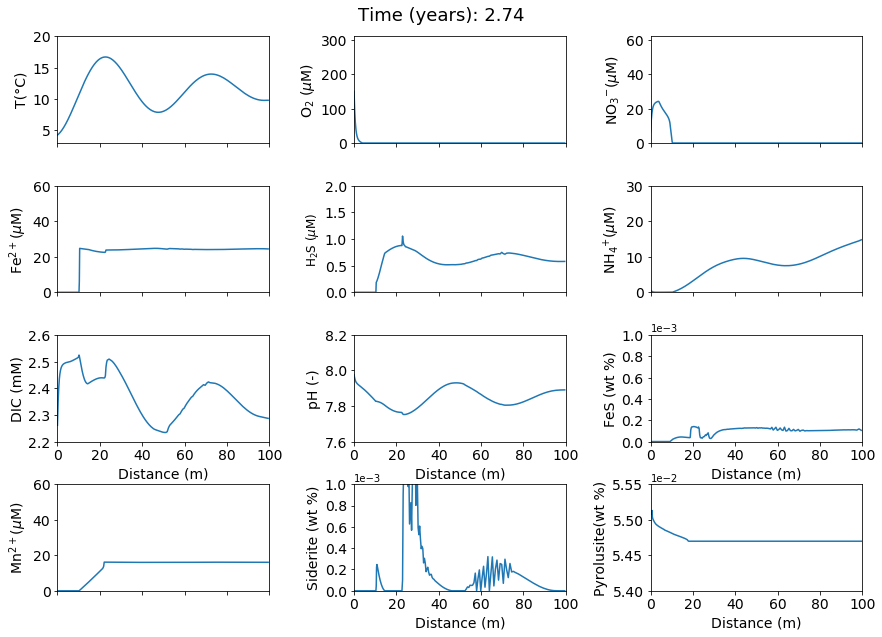

In [6]:
## Plot cross-sections of the salinity and flow field at various output times

i=1000

plt.figure(2,figsize=(13,10))

plt.clf()

ax=plt.subplot(4,3,1)
plt.plot(xi,c_t[i][0,0,:])
ax.set_xticklabels([])
plt.yticks(fontsize=14)
plt.ylim([3,20])
plt.xlim([0,100])
plt.ylabel('T(°C)',fontsize=14)
t1=ax.text(142,22.5,'Time (years): %1.2f' % (i/365),fontsize=18)

ax=plt.subplot(4,3,2)
plt.plot(xi,c_o2[i][0,0,:]*1e6/2)
ax.set_xticklabels([])
plt.yticks(fontsize=14)
plt.ylim([0,310])
plt.xlim([0,100])
plt.ylabel('O$_2$ ($\mu$M)',fontsize=14)

ax=plt.subplot(4,3,3)
plt.plot(xi,c_no3[i][0,0,:]*1e6)
ax.set_xticklabels([])
plt.yticks(fontsize=14)
plt.ylim([0,62])
plt.xlim([0,100])
plt.ylabel('NO$_3$$^{-}$($\mu$M)',fontsize=14)

ax=plt.subplot(4,3,4)
plt.plot(xi,c_fe2[i][0,0,:]*1e6)
plt.yticks(fontsize=14)
ax.set_xticklabels([])
plt.ylim([0,60])
plt.xlim([0,100])
plt.ylabel('Fe$^{2+}$($\mu$M)',fontsize=14)

ax=plt.subplot(4,3,5)
l6,=plt.plot(xi,c_hs[i][0,0,:]*1e6)
plt.yticks(fontsize=14)
ax.set_xticklabels([])
plt.ylim([0,2])
plt.xlim([0,100])
plt.ylabel('H$_2$S ($\mu$M)',fontsize=12)

ax=plt.subplot(4,3,6)
l5,=plt.plot(xi,c_amm[i][0,0,:]*1e6)
plt.yticks(fontsize=14)
ax.set_xticklabels([])
plt.ylim([0,30])
plt.xlim([0,100])
plt.ylabel('NH$_4$$^{+}$($\mu$M)',fontsize=14)

ax=plt.subplot(4,3,7)
l1,=plt.plot(xi,c_c4[i][0,0,:]*1e3)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([2.2,2.6])
plt.xlim([0,100])
plt.ylabel('DIC (mM)',fontsize=14)
plt.xlabel('Distance (m)',fontsize=14)

ax=plt.subplot(4,3,8)
l1,=plt.plot(xi,c_ph[i][0,0,:])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([7.6,8.2])
plt.xlim([0,100])
plt.ylabel('pH (-)',fontsize=14)
plt.xlabel('Distance (m)',fontsize=14)

ax=plt.subplot(4,3,9)
l1,=plt.plot(xi,c_fes[i][0,0,:]*(32+56)*n/(2650*(1-n))*100)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))

plt.xticks(fontsize=14)
plt.ylim([0,1.0e-3])
plt.xlim([0,100])
plt.ylabel('FeS (wt %)',fontsize=14)
plt.xlabel('Distance (m)',fontsize=14)

ax=plt.subplot(4,3,10)
plt.plot(xi,c_mn2[i][0,0,:]*1e6)
plt.yticks(fontsize=14)
ax.set_xticklabels([])
plt.ylim([0,60])
plt.xlim([0,100])
plt.ylabel('Mn$^{2+}$($\mu$M)',fontsize=14)

ax=plt.subplot(4,3,11)
l1,=plt.plot(xi,c_sid[i][0,0,:]*(116)*n/(2650*(1-n))*100)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.xticks(fontsize=14)
plt.ylim([0,1.0e-3])
plt.xlim([0,100])
plt.ylabel('Siderite (wt %)',fontsize=14)
plt.xlabel('Distance (m)',fontsize=14)

ax=plt.subplot(4,3,12)
l1,=plt.plot(xi,(c_pyr[i][0,0,:])*(87)*n/(2650*(1-n))*100-0.45)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.xticks(fontsize=14)
plt.ylim([5.4e-2,5.55e-2])
plt.xlim([0,100])
plt.ylabel('Pyrolusite(wt %)',fontsize=14)
plt.xlabel('Distance (m)',fontsize=14)

plt.subplots_adjust(bottom=0.15,top=0.92,right=0.96,left=0.1,wspace=0.4,hspace =0.4)